# pc-gym showcase 
Author: Max Bloor (max.bloor22@imperial.ac.uk) \\

Notebook showcasing the current pc-gym version.


## Libraries

In [1]:
from Models import Models_env #import the models 
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import gymnasium as gym
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO

## 1. Reactor Case Study

Define the gym environment for a CSTR

In [2]:
#Global params
T = 26
nsteps = 100
#Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    '0': [0.8 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

#Continuous box action space
action_space = {
    'low': np.array([-1]),
    'high':np.array([1]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

env_params = {
    'Nx': 2, # Number of states
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'Nu':1, # Number of control/actions
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'dt': 1., # Time step
    'x0': np.array([0.8,330,0.8]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode', #Select the model
    'r_scale': np.array([5]), #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise': True, #Normalise the states 
}
env = Models_env(env_params)


In [3]:
initial_policy = PPO('MlpPolicy', env, verbose=1,learning_rate=0.01).learn(30000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -3.29    |
| time/              |          |
|    fps             | 555      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.65       |
| time/                   |             |
|    fps                  | 556         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009175343 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss  

Rollout and plot the trained policy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


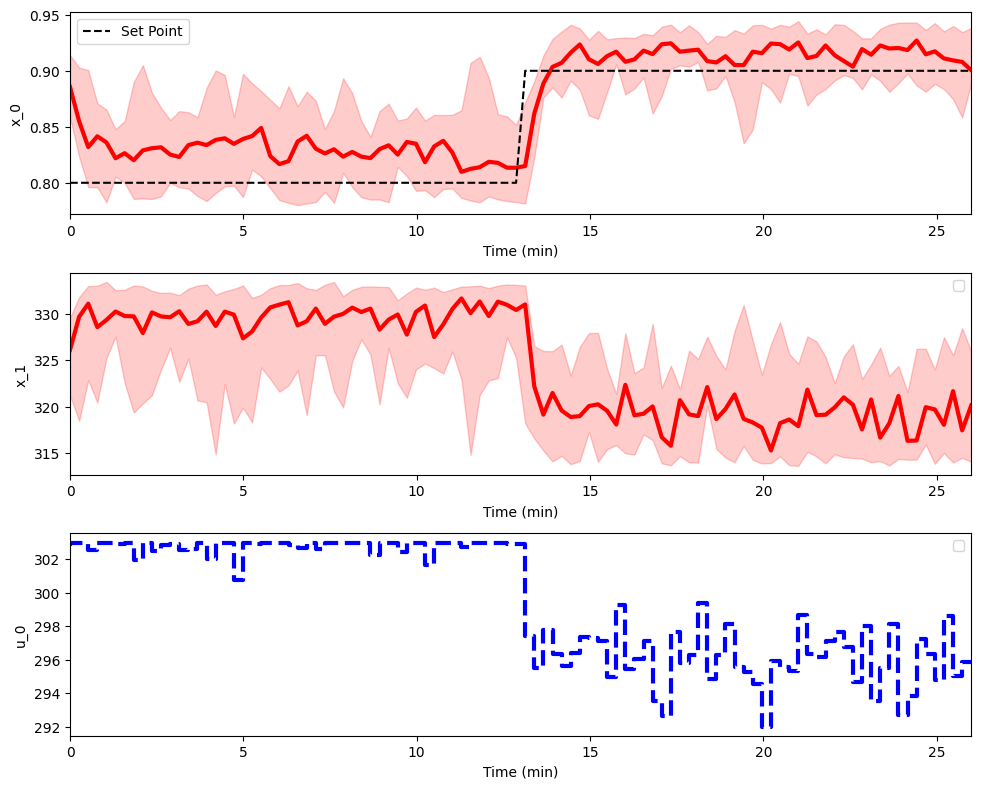

In [4]:
env.plot_rollout(initial_policy,10)

## 2. Disturbance Function

Step disturbance to the inlet concentration between ~6 and ~19 minutes into the episode is defined. Then the previously trained policy is rolled out with this disturbance. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


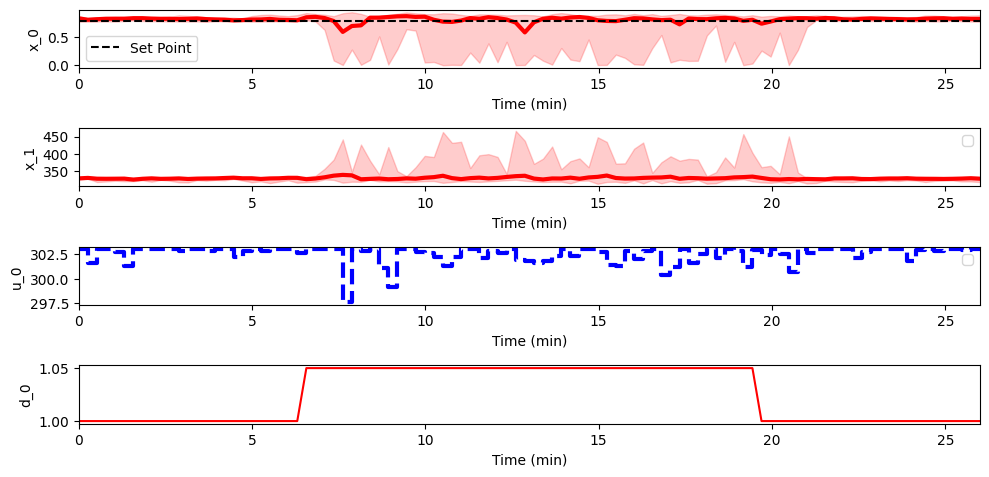

In [5]:
SP = {
    '0': [0.8 for i in range(int(nsteps))]
}
disturbance = {
    0: np.array([None for i in range(int(nsteps))]),
    1: np.array([1 for i in range(int(nsteps/4))]+[1.05 for i in range(int(nsteps/2))]+[1 for i in range(int(nsteps/4))]),
}

env_params.update({'disturbances': disturbance,
                'SP': SP},
                )
env = Models_env(env_params)
env.plot_rollout(initial_policy,10)

Given the previous policy's poor performance the policy is retrained on episodes with the disturbance. 

In [6]:
dist_policy = PPO('MlpPolicy', env, verbose=1,learning_rate=0.01).learn(total_timesteps=30000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -7.42    |
| time/              |          |
|    fps             | 286      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -11.4       |
| time/                   |             |
|    fps                  | 248         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007562488 |
|    clip_fraction        | 0.0812      |
|    clip_range           | 0.2         |
|    entropy_loss  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


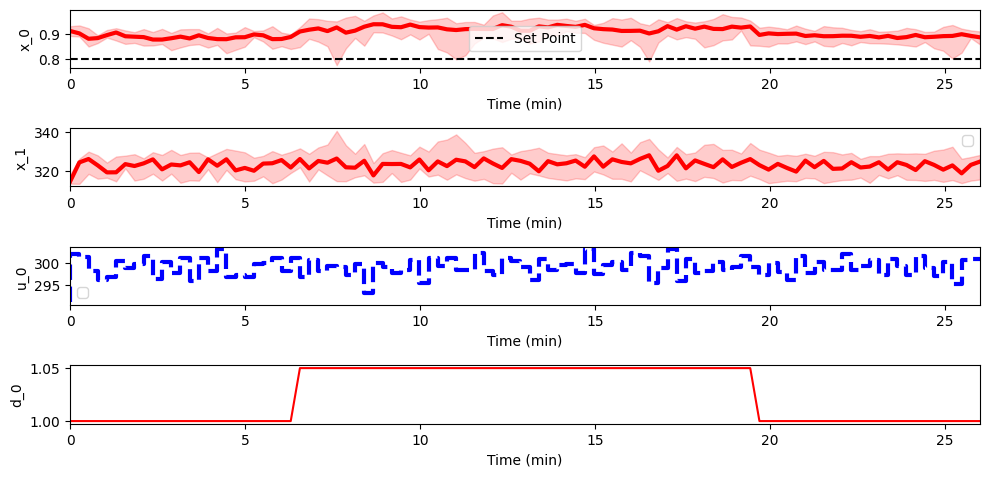

In [7]:
env.plot_rollout(dist_policy,10)   

## 3. Constraint Function

The constraint is defined in the environment and the reward penalty is activated to encourage policies which do not violate the constraint.

In [8]:
cons = {
    '0': None,
    '1' :332
}

cons_type = {
    '1':'<='
}

env_params.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params.get('constraints') is not None
env = Models_env(env_params)

A constraint is shown at a reactor temperature of 332 K.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


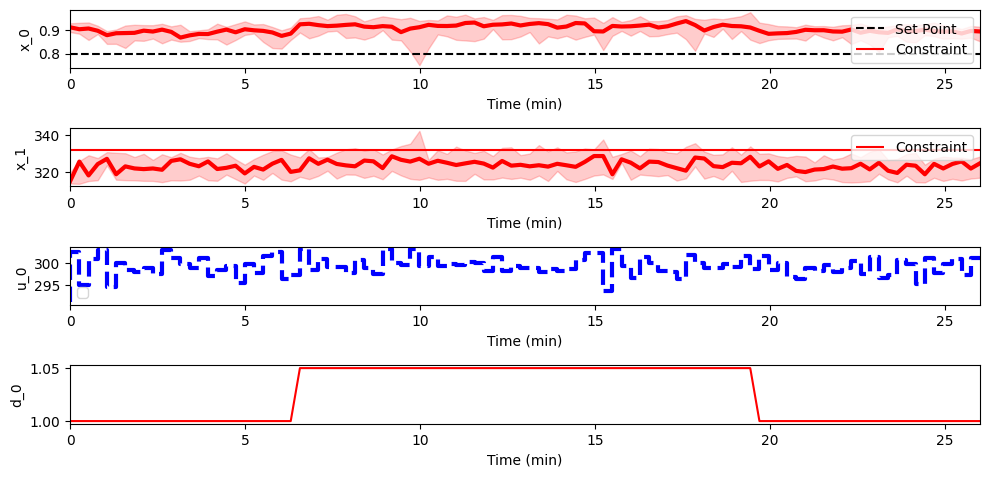

In [9]:
env.plot_rollout(dist_policy,10)

Train with the constraint penalty

In [10]:
cons_policy = PPO('MlpPolicy', env, verbose=1,learning_rate=0.01).learn(total_timesteps=30000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -1.01e+03 |
| time/              |           |
|    fps             | 291       |
|    iterations      | 1         |
|    time_elapsed    | 7         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.04e+03   |
| time/                   |             |
|    fps                  | 251         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009990266 |
|    clip_fraction        | 0.0869      |
|    clip_range           | 0.2         |
|    entr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


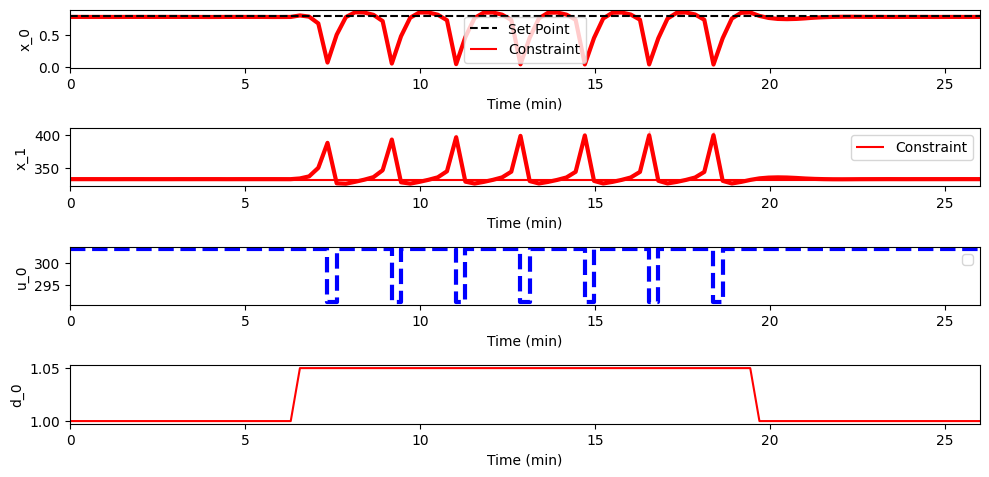

In [12]:
env.plot_rollout(cons_policy,10)